**Exercise set 9**
==============

>The goal of this exercise is to exemplify how decision trees
>are created, and how we can perform PLSR regression and decision tree
>classification for relatively complex data sets. 

**Exercise 9.1**

Table 1 list certain conditions in which our friend Hermann
is playing tennis. Use this data to create a decision tree (by hand) for whether or
not Hermann is playing tennis. Construct the tree by using the information entropy
and information gain.


|**Outlook**  | **Wind** | **Humidity** | **Playing tennis**  |
|:---|:---|:---|:---|
|overcast | strong | normal | yes |
|sunny    | strong | normal | yes |
|rain     | weak   | high   | yes |
|sunny    | strong | high   | no  |
|sunny    | weak   | high   | no  |
|sunny    | weak   | normal | yes |
|rain     | strong | high   | no  |
|**Table 1:** *Conditions for which Hermann is playing tennis.*|

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42) #Seed all random number generators to make this notebook reproducable
import pandas as pd
import graphviz

outlook gain: 0.12808527889139443
wind gain: 0.020244207153756077
humidity gain: 0.5216406363433185
layer 2
outlook gain: 0.31127812445913283
wind gain: 0.31127812445913283
layer 3
wind gain: 1.0


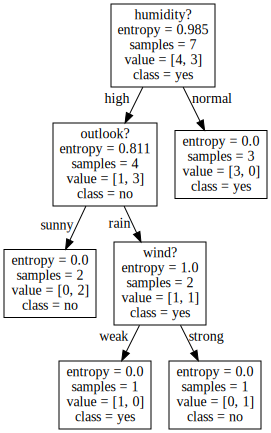

In [2]:
def entropy(data):
    entr = 0
    for cls in set(data):
        prob = sum([1 for i in data if i == cls])/len(data)
        entr -= prob*np.log2(prob)
    return entr


def gain_f(var, data):
    gain = entropy(data)
    for v in set(var):
        prob = sum([1 for i in var if i == v])/len(var)
        subdata = [data[i] for i,e in enumerate(var) if e == v]
        gain -= prob*entropy(subdata)
    return gain

def split(variables, data, names, name='root'):
    
    print("{} split".format(name))
    
# Code the data
tennis = ['yes', 'yes', 'yes', 'no', 'no', 'yes', 'no']

# 
variables = {
    'outlook' :['overcast', 'sunny', 'rain', 'sunny', 'sunny', 'sunny', 'rain'],
    'wind' : ['strong', 'strong', 'weak', 'strong', 'weak', 'weak', 'strong'],
    'humidity' : ['normal', 'normal', 'high', 'high', 'high', 'normal', 'high']
}


for name, i in variables.items():
    print("{} gain: {}".format(name, gain_f(i, tennis)))

# Pick humidity=high

tennis = ['yes', 'no', 'no', 'no']


variables = {
    'outlook' :['rain', 'sunny', 'sunny', 'rain'],
    'wind' : ['weak', 'strong', 'weak', 'strong'],
}

print("layer 2")
for name, i in variables.items():
    print("{} gain: {}".format(name, gain_f(i, tennis)))

# Pick outlook=rain
tennis = ['yes', 'no']


variables = {
    'wind' : ['weak', 'strong'],
}
print("layer 3")
for name, i in variables.items():
    print("{} gain: {}".format(name, gain_f(i, tennis)))


dot = """
digraph Tree {
node [shape=box] ;
0 [label="humidity?\nentropy = 0.985\nsamples = 7\nvalue = [4, 3]\nclass = yes"] ;
1 [label="outlook?\nentropy = 0.811\nsamples = 4\nvalue = [1, 3]\nclass = no"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="high"] ;
2 [label="entropy = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = yes"] ;
0 -> 2 [labeldistance=3.2, labelangle=-40, headlabel="normal"];
3 [label="entropy = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = no"] ;
1 -> 3 [labeldistance=2.5, labelangle=45, headlabel="sunny"] ;
4 [label="wind?\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = yes"] ;
1 -> 4 [labeldistance=2.8, labelangle=25, headlabel="rain"] ;
5 [label="entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = yes"];
6 [label="entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = no"];
4 -> 5 [labeldistance=2.5, labelangle=45, headlabel="weak"];
4 -> 6 [labeldistance=2.5, labelangle=-45, headlabel="strong"];
}
"""
graphviz.Source(dot) 

**Exercise 9.2**

[Windig and Stephenson](https://doi.org/10.1021/ac00046a015) have measured near-infrared spectra
for 140 mixtures of the solvents methylene chloride, 2-butanol, methanol,
dichloropropane, and acetone. We will in this exercise see if we can
predict the compositions of the mixtures from the spectra.
Each of the $140$ spectra have been sampled at $700$ wavelengths
between $1100$ and $2500$ nm. The raw data containing the spectra
and the corresponding concentrations can be found in the file
[`Data/windig.csv`](Data/windig.csv).



**(a)**  Create a partial least-squares regression (PLSR) model for predicting
the concentrations. Use $1$ PLS component for your first model and
assess it using $R^2$, RMSEC, RMSECV and RMSEP. The raw data can
be loaded as shown below.
```python
"""Load the Windig data set."""
import pandas as pd
data = pd.read_csv('Data/windig.csv')
X = data.filter(like='data', axis=1).values  # NIR spectra
Y = data.filter(like='concentrations', axis=1).values  # Concentrations
```

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

data = pd.read_csv('Data/windig.csv')
X = data.filter(like='data', axis=1).values  # NIR spectra
y = data.filter(like='concentrations', axis=1).values  # Concentrations

X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize PLSR regression
model = PLSRegression(n_components=1)

def score_models(models, X_train, X_test, y_train, y_test):
    # Make 5 empty lists
    r2_trains, r2_tests, RMSECs, RMSEPs, RMSECVs = [], [], [], [], []
    
    for model in models:
        # Train the model
        model.fit(X_train, y_train)

        # Get prediction
        y_hat_train = model.predict(X_train)
        y_hat_test = model.predict(X_test)


        # Get r2 of the train and test set
        r2_train = r2_score(y_train, y_hat_train)
        r2_test = r2_score(y_test, y_hat_test)



        # Get RMSEC (calibration) and RMSEP (prediction)
        RMSEC = np.sqrt(mean_squared_error(y_train, y_hat_train))
        RMSEP = np.sqrt(mean_squared_error(y_test, y_hat_test))

        # Do RMSEC
        scores = cross_val_score(model, X_train, y_train,
                                 scoring='neg_mean_squared_error',
                                 cv=len(X_train))
        # Take the square root of -scores:
        RMSECV = np.sqrt(-scores)
        
        r2_trains.append(r2_train)
        r2_tests.append(r2_test)
        RMSECs.append(RMSEC)
        RMSEPs.append(RMSEP)
        RMSECVs.append(RMSECV)

    return r2_trains, r2_tests, RMSECs, RMSEPs, RMSECVs

r2_train, r2_test, RMSEC, RMSEP, RMSECV = score_models([model],
                                                       X_train, 
                                                       X_test,
                                                       y_train,
                                                       y_test)
print("R2 train: {}\n".format(r2_train[0]) +
      "R2 test: {}\n".format(r2_test[0]) +
      "RMSEC: {}\n".format(RMSEC[0]) +
      "RMSEP: {}\n".format(RMSEP[0]) +
      "RMSECV: {} ± {}\n".format(RMSECV[0].mean(), RMSECV[0].std()) 
     )

R2 train: 0.23308046669606014
R2 test: 0.22265749954224034
RMSEC: 10.630808787058962
RMSEP: 10.615194310035351
RMSECV: 10.246094403315851 ± 3.544528436385676



**(b)** Improve your PLSR model by including more
PLS components. Try components in the
range from $2$ up to $15$ and compare the different models. How many
PLS components are you satisfied with? In the following, we will refer
to the model you are most satisfied with as "model A".



<IPython.core.display.Javascript object>


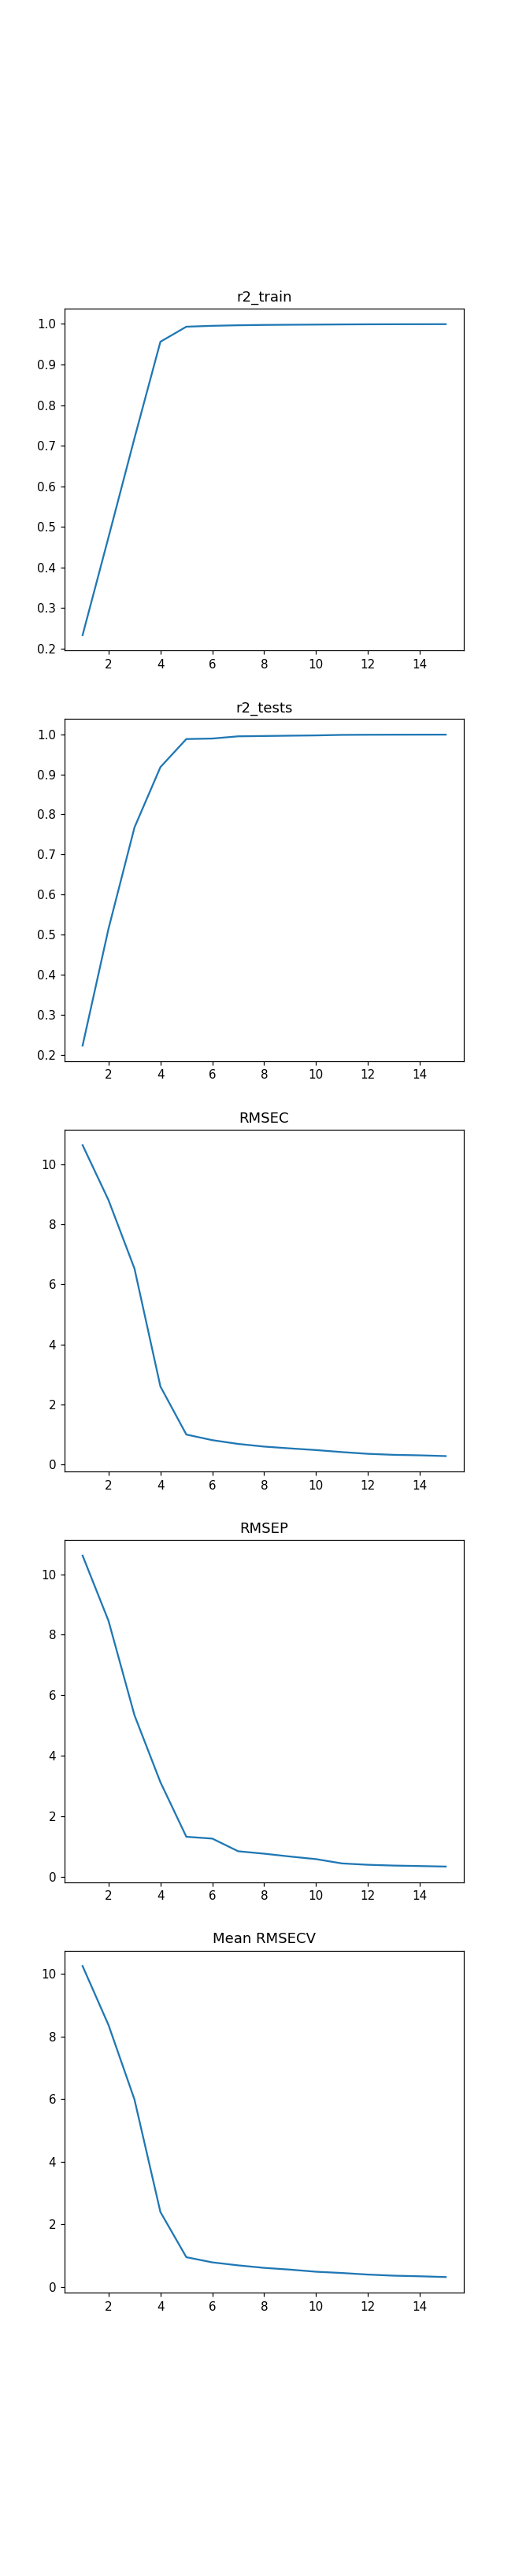

In [4]:
import matplotlib.pyplot as plt

models = [PLSRegression(n_components=i) for i in range(1,16)]
r2_trains, r2_tests, RMSECs, RMSEPs, RMSECVs = score_models(models,
                                                            X_train,
                                                            X_test,
                                                            y_train,
                                                            y_test)
RMSECVm = [i.mean() for i in RMSECVs]
scores = [r2_trains, r2_tests, RMSECs, RMSEPs, RMSECVm]
names = ['r2_train', 'r2_tests', 'RMSEC', 'RMSEP', 'Mean RMSECV']

fig, axs = plt.subplots(5,1, figsize=(6,30))
axs = axs.flatten()
for score, name, ax in zip(scores, names, axs):
    ax.plot(range(1,16), score)
    ax.set_title(name)

**Answer to question 9.2(b):** The **elbow** in most of the plots is at `n_components=5` so we will pick that as `model A`

**(c)**  Plot the regression coefficients for model A (see point **(b)**).



# components for model A: 5


<IPython.core.display.Javascript object>


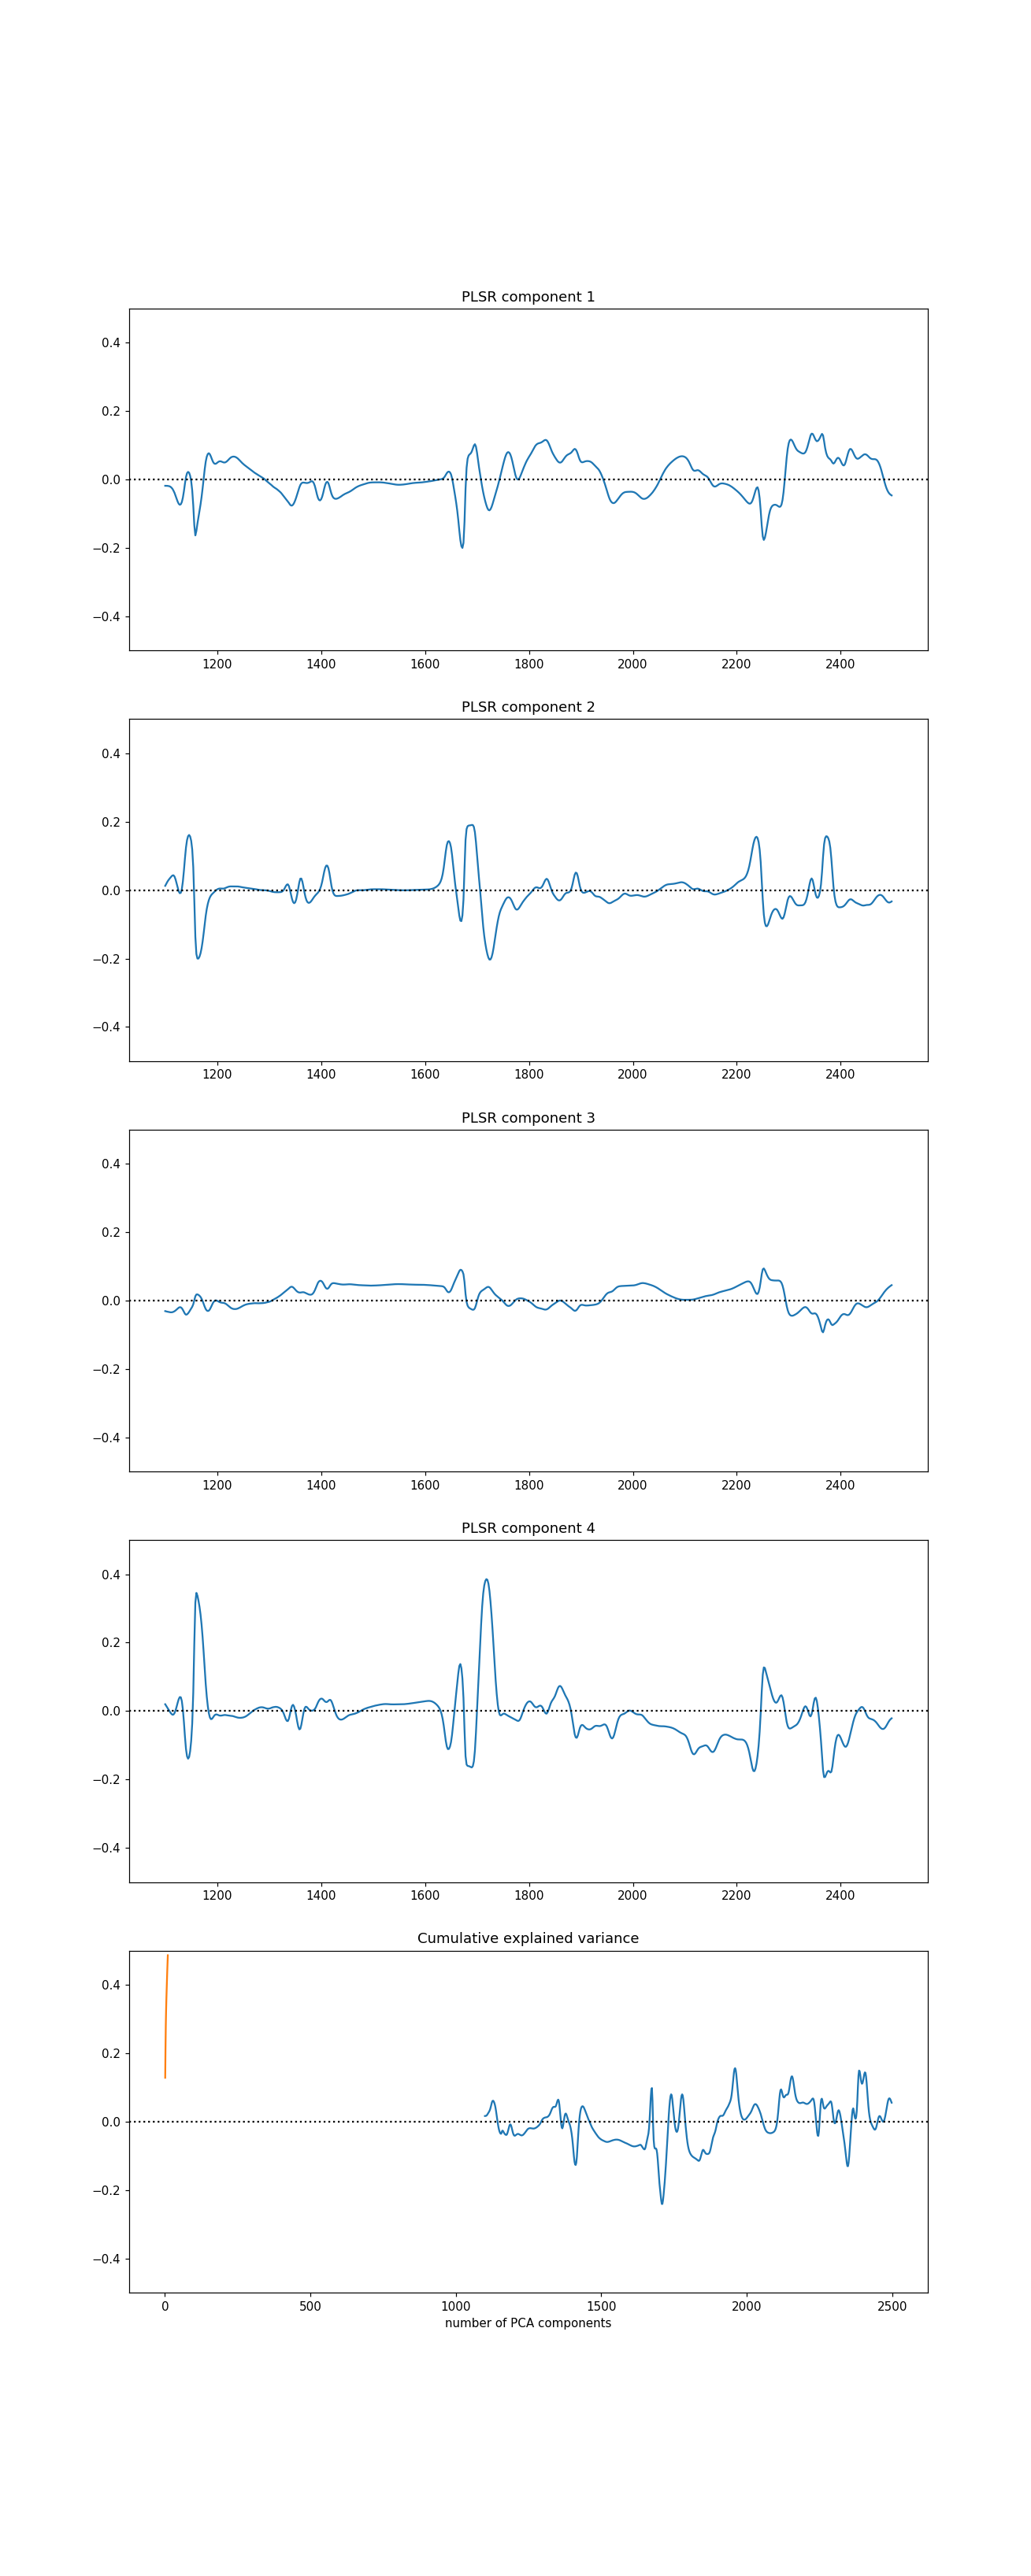

In [5]:
modelA = models[4] # Pick the 5th model
print("# components for model A: {}".format(modelA.n_components))
B = modelA.coef_
fig, axs = plt.subplots(5, 1, figsize=(12, 30))
axs = axs.flatten()
for i, coef in enumerate(B.T):
    ax = axs[i]
    ax.plot(range(1100, 2500, 2), coef)
    ax.set_title('PLSR component {}'.format(i+1))
    ax.axhline(ls=':', c='k')
    ax.set_ylim(-0.5, 0.5)

**(d)**  If you are given a new spectrum of a mixture of methylene chloride,
2-butanol, methanol, dichloropropane, and acetone, how well would
your model A predict the concentrations of the different solvents
in the mixture?

In [6]:
y_hats = modelA.predict(X_test)
names = ['methylene chloride', '2-butanol', 'methanol', 'dichloropropane', 'acetone']
for i, name in enumerate(names):
    print("R2 {}: {}".format(name, r2_score(y_test.T[i],y_hats.T[i])))

R2 methylene chloride: 0.9904982127276988
R2 2-butanol: 0.993591682558518
R2 methanol: 0.9954324559403975
R2 dichloropropane: 0.976775571385234
R2 acetone: 0.9845311082597762


**Answer to question 9.2(d):** It will be able to predict the different solvents with more than 97% accuracy

**(e)**  Create a least-squared model for predicting the concentrations.
Assess it using $R^2$, RMSEC, RMSECV and RMSEP. Does this model
perform as you expect?

In [7]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
r2_train, r2_test, RMSEC, RMSEP, RMSECV = score_models([model],
                                                       X_train, 
                                                       X_test,
                                                       y_train,
                                                       y_test)
print("R2 train: {}\n".format(r2_train[0]) +
      "R2 test: {}\n".format(r2_test[0]) +
      "RMSEC: {}\n".format(RMSEC[0]) +
      "RMSEP: {}\n".format(RMSEP[0]) +
      "RMSECV: {} ± {}\n".format(RMSECV[0].mean(), RMSECV[0].std()) 
     )

R2 train: 1.0
R2 test: 0.9994806348296279
RMSEC: 1.2367814446712684e-13
RMSEP: 0.29089489260736795
RMSECV: 0.16428241719288375 ± 0.07011644258986555



**Answer to question 9.2(e):** It performs well above what we expected. Keep in mind that we have over 700 variables to describe 140 samples, so we might have some overfitting/correlation issues


**Exercise 9.3**

[Schummer *et al.*](https://doi.org/10.1016/S0378-1119(99)00342-X) studied ovarian cancer by measuring gene expression
values for $1536$ genes in both normal and tumor tissues. One of their goals was
to find genes that were overexpressed in tumor samples compared with normal samples.
This knowledge may be used for tumor diagnosis. The raw data can be
found in the file [`Data/ovo.csv`](Data/ovo.csv).


**(a)**  Perform a principal component analysis (PCA) on the gene expression data,
and obtain the explained variance when using $1$, $2$, $5$ and $10$
components.

Center the data before performing the PCA. This can be
done as follows with the `scale` method
from `sklearn.preprocessing`: `X = scale(X, with_std=False)`.

The raw data can
be loaded as shown below.
```python
"""Load the Windig data set."""
import pandas as pd
data = pd.read_csv('Data/ovo.csv')
classes = data['objlabels']  # Classification of data points.
X = data.filter(like='X.', axis=1)  # Gene expressions.
```




In [8]:
"""Load the Windig data set."""
import pandas as pd
data = pd.read_csv('Data/ovo.csv')
classes = data['objlabels']  # Classification of data points.
X = data.filter(like='X.', axis=1)  # Gene expressions.


from sklearn.decomposition import PCA
X = scale(X, with_std=False)


pca = PCA(n_components=10)
pca.fit(X)
expl_var = pca.explained_variance_ratio_
cum_expl_var = [sum(expl_var[:i]) for i in range(1,11)]
plt.plot(range(1,11), cum_expl_var)
plt.title("Cumulative explained variance")
plt.xlabel("number of PCA components")
for i in [1, 2, 5, 10]:
    print("Explained variance for {} components: {}".format(i, cum_expl_var[i-1]))

Explained variance for 1 components: 0.1279695287562419
Explained variance for 2 components: 0.21223083327703401
Explained variance for 5 components: 0.35675175264600595
Explained variance for 10 components: 0.48605840681858137


**(b)**  Inspect the data by plotting the scores and loadings for principal component
number $1$ and principal component number $2$:

* (i)  Can you observe any clustering
of the samples?

* (ii)  Are there any outliers among the samples?

* (iii)  Can you identify some
genes which are overexpressed in tumors? 

* (iv)  Can you identify some
genes which are underexpressed in tumors? 





<IPython.core.display.Javascript object>


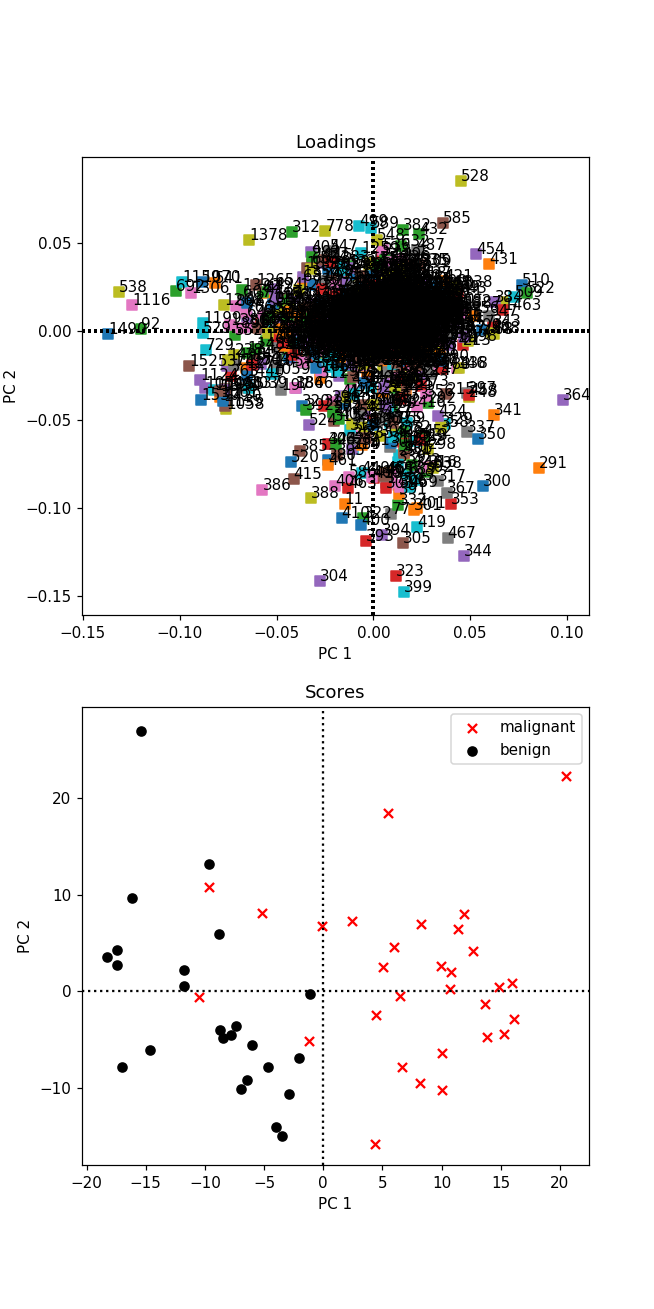

In [9]:

scores = pca.transform(X)
loadings = pca.components_

fig, axs = plt.subplots(2, 1, figsize=(6,12))
axs = axs.flatten()

#plot loadings
ax = axs[0]
for x, y, label in zip(loadings[0, :], loadings[1, :], range(loadings.shape[1])):
    ax.scatter(x, y, marker=',')
    ax.text(x, y, label)
    ax.axhline(ls=':', c='k')
    ax.axvline(ls=':', c='k')
ax.set_title("Loadings")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# Plot scores
ax = axs[1]
# Label malignant cells
s_label = np.array([1 if 'C' in name else 0 for name in data['olabels']])
c = np.where(s_label==1)
n = np.where(s_label==0)

# Plot the malignant cells
ax.scatter(scores[c,0], scores[c,1], c='red', marker='x', label='malignant')

# Plot the benign cells
ax.scatter(scores[n,0], scores[n,1], c='black', marker='o', label='benign')
ax.legend()
ax.axhline(ls=':', c='k')
ax.axvline(ls=':', c='k')
ax.set_title("Scores")

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2");

**Answer to question 9.3(b):**

(i) From looking at the scores plot, PC 1 seems to seperate malignant and benign cells.

(ii) There seems to be about 4 outliers that are on the wrong side of PC 1 from what you would expect

(iii) Looking at the loadings plot (using the zoom function): gene 364, 509, 510, and 511 are in the same direction of PC1 as the malignant cells in the score plot

(iv) With the same method as (iii): genes 1490, 538, 1116, and 92 seem to have an oposite correlation in PC 1 with malignant cells

**(c)**  Based on your answer in **(b)**, can
you identify some pairs of genes that seem to distinguish between
normal and tumor tissues? Support your findings by plotting the raw data.

<IPython.core.display.Javascript object>


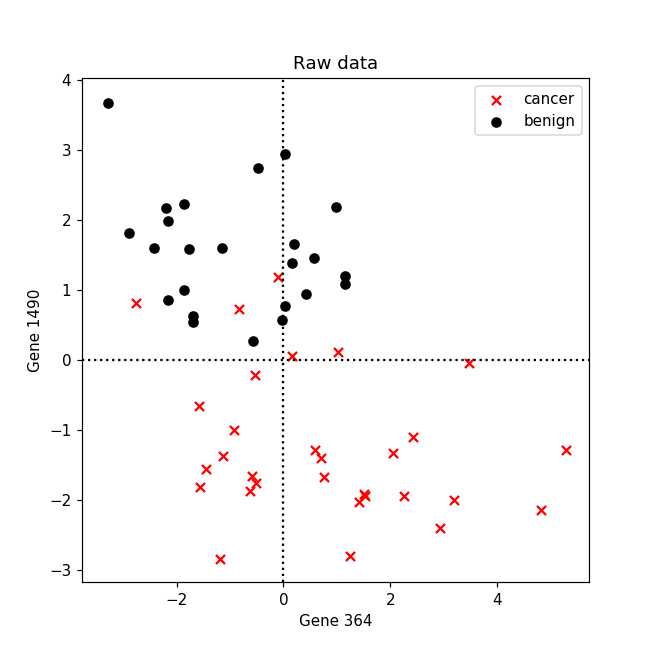

In [10]:
# Your code here
# We will use gene 364 (positive correlation) and 1490 (negative correlation)

fig, ax = plt.subplots(1, 1, figsize=(6,6))

pos = 364
neg = 1490

# Plot the ra data in the same vain as the scores
# Plot the malignant cells
ax.scatter(X[c,pos], X[c,neg], c='red', marker='x', label='cancer')

# Plot the benign cells
ax.scatter(X[n,pos], X[n,neg], c='black', marker='o', label='benign')
ax.legend()
ax.axhline(ls=':', c='k')
ax.axvline(ls=':', c='k')
ax.set_title("Raw data")

ax.set_xlabel("Gene {}".format(pos))
ax.set_ylabel("Gene {}".format(neg));


**Answer to question 9.3(c):** As you can see in the plot above: having a higher gene 364 has a higher chance of being malignant, while having a higher gene 1490 gives a higher chance of being benign

**(d)**  Create a classifier for this data set using a decision tree. Limit the depth of the decision
tree to $2$. Assess the classifier, and compare it with your findings in **(c)** .



<IPython.core.display.Javascript object>


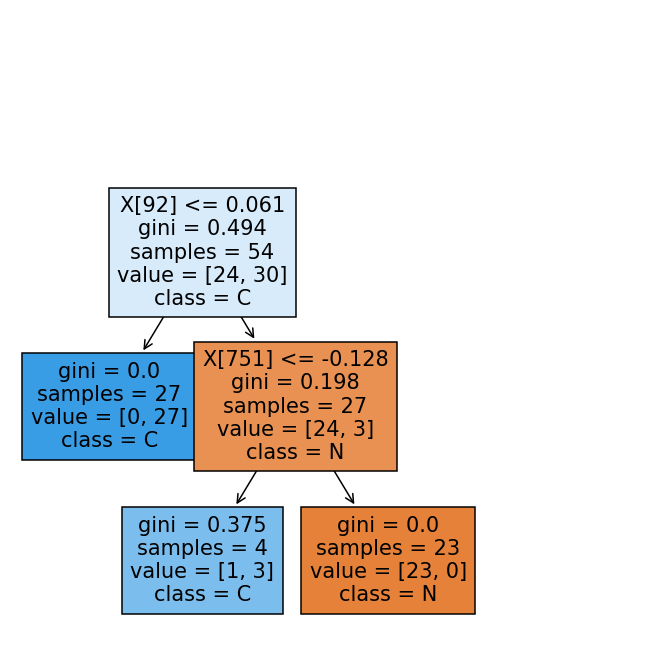

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
model = DecisionTreeClassifier(max_depth=2, random_state=42)
model.fit(X, s_label)
fig, ax = plt.subplots(1,1,figsize=(6,6))
plot_tree(model, filled=True, class_names=['N', 'C'], ax=ax);
fig.tight_layout()

**Answer to question 9.3(d):** The decision tree found a similar answer for the first gene (92), but gene 751 was not on our radar. That is because the ones with positive and negative correlation with malignant tumors, also have a negative correlation with eachother (as you can see in the scatterplot of the raw data). So picking of these leads to a smaller amount of information gain in the others, which makes other genes pop up as the second question.

**(e)**  Create a random forest classifier for the data set. Set the maximum depth to $2$, and
use $500$ trees in your forest (i.e. set `n_estimators=500`). Assess the
classifier and plot the
variable importance for the $20$ most important variables. Compare this with your
previous findings.

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0


<IPython.core.display.Javascript object>


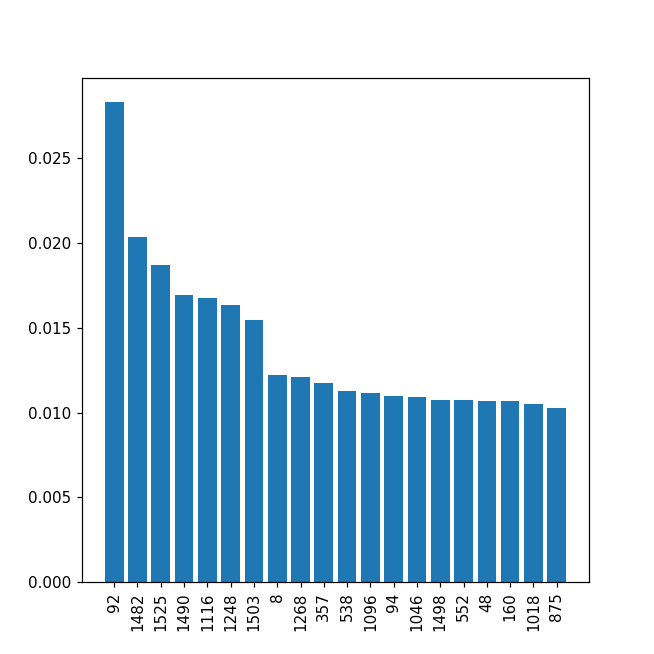

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

RF = RandomForestClassifier(n_estimators=500, max_depth=2, random_state=42)
RF.fit(X, s_label)

# Copy some code from solutions 08
def conf_matrix(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    index = ['neg', 'pos']
    columns = ['predicted neg', "predicted pos"]
    df = pd.DataFrame(cm, columns=['predicted neg', "predicted pos"], index=['neg', 'pos'])
    
    # Some swapping  and inversing of axis is required to match wikipedia layout
    return df[columns[::-1]].T[index[::-1]]

def accuracy(cm):
    acc = cm['pos']['predicted pos'] + cm['neg']['predicted neg']
    acc /= sum(cm['pos'])+sum(cm['neg'])
    return acc

def precision(cm):
    cm = cm.T
    prec = cm['predicted pos']['pos'] / sum(cm['predicted pos'])
    return prec

def recall(cm):
    rec = cm['pos']['predicted pos']
    rec /= sum(cm['pos'])
    return rec

def f1(cm):
    tp = cm['pos']['predicted pos']
    fp = cm['neg']['predicted pos']
    fn = cm['pos']['predicted neg']
    return 2*tp/(2*tp+fp+fn)
 
y_hat = RF.predict(X)
cm = conf_matrix(s_label, y_hat)
print("accuracy: {}".format(accuracy(cm)))
print("precision: {}".format(precision(cm)))
print("recall: {}".format(recall(cm)))
print("F1: {}".format(f1(cm)))

important_features = np.argsort(RF.feature_importances_)
fig, ax = plt.subplots(1, 1, figsize=(6,6))

xs = [i+0.5 for i in range(20)]
ax.bar(xs, RF.feature_importances_[important_features[-20:]][::-1])
ax.set_xticks(xs)
names = [str(i) for i in important_features[-20:][::-1]]
ax.set_xticklabels(names, rotation=90, ha='center');


**Answer to question 9.3(e):** 

Only genes that we determined before to have a negative correlation with malignant cells seem to pop up in the random forest: 1490, 538, 1116, and 92